In [14]:
import warnings

warnings.filterwarnings("ignore")
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
from collections import Counter
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

stop_words = set(stopwords.words('english'))

In [15]:
file_path = 'for_lda_reviews1.csv'  
reviews_df = pd.read_csv(file_path)

In [16]:
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    words = [word for word in text.split() if word not in stop_words]
    return words

In [17]:
all_words = []
for review in reviews_df['review']:
    if pd.notna(review):
        all_words.extend(preprocess_text(review))

# Calculate word frequencies
word_freq = FreqDist(all_words)

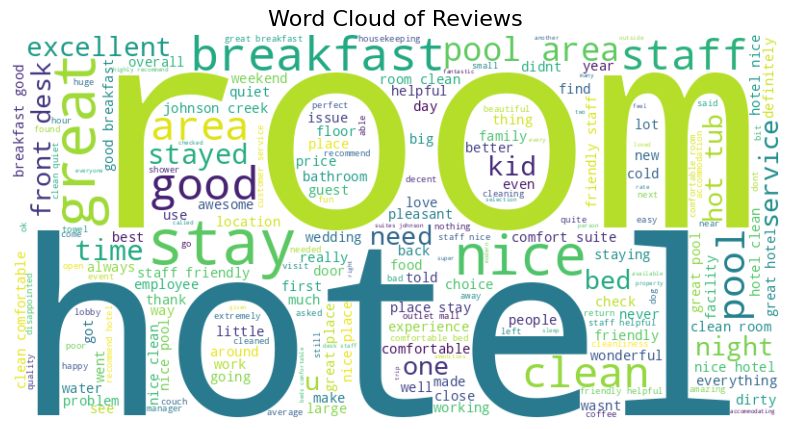

In [18]:
# Import necessary libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all cleaned words into a single string
cleaned_text = ' '.join(all_words)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cleaned_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.title('Word Cloud of Reviews', fontsize=16)
plt.show()


In [19]:
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [20]:
def compute_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    sentiment_label = torch.argmax(probabilities, dim=1).item()
    sentiment_labels = {0: 'very negative', 1: 'negative', 2: 'neutral', 3: 'positive', 4: 'very positive'}
    return sentiment_labels[sentiment_label]

In [21]:
# Replace input() with the parameter `aspects`
try:
    user_aspects
except NameError:
    user_aspects = ["service", "price", "cleanliness", "location", "ambiance"]  # Default values for testing


In [22]:
aspect_sentiments = {aspect: [] for aspect in user_aspects}

In [23]:

for review in reviews_df['review']:
    if pd.notna(review):
        for aspect in user_aspects:
            if aspect in review.lower(): 
                sentiment = compute_sentiment(review)
                aspect_sentiments[aspect].append(sentiment)

aspect_sentiment_summary = {}
for aspect, sentiments in aspect_sentiments.items():
    sentiment_counts = Counter(sentiments)
    total = sum(sentiment_counts.values())
    sentiment_distribution = {sent: count / total * 100 for sent, count in sentiment_counts.items()}
    aspect_sentiment_summary[aspect] = sentiment_distribution

aspect_sentiment_df = pd.DataFrame(aspect_sentiment_summary).fillna(0)
aspect_sentiment_df


                   hotel   breakfast       food        bed        kid
negative        6.435006    5.296610   7.692308  10.101010   9.195402
very negative   6.692407    2.754237   7.692308  10.606061   4.597701
neutral        15.958816   14.406780  19.230769  14.141414   8.045977
positive       28.828829   36.440678  32.051282  30.303030  35.057471
very positive  42.084942   41.101695  33.333333  34.848485  43.103448
